In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
import matplotlib.patches as mpatches

/home/raul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
N_ROWS = 7
N_COLS = 7
GRID_WORLD = np.zeros((N_ROWS, N_COLS))-1


GRID_WORLD[(0,0)] = 100 # Initial Target Position
#GRID_WORLD[TARGET_POS2] = -10


ACTIONS = ['Left', 'Right', 'Up', 'Down']

GAMMA = .9
ALPHA = 0.1
MIN_EPSILON = 0.03

In [3]:

class AdaptativeAgent():
    
    def __init__(self, initial_state, world_knowledge, decay_rate=0.06):
        self.step = 0
        self.time = 0
        self.current_reward = 0
        self.decay_rate = decay_rate
        self.adapt_flag = []
        self.initial_state = initial_state
        self.current_state = initial_state
        self.knowledge = {(i,j): {'short_memory':[]} for i in range(N_ROWS) for j in range(N_COLS)}
        self.world_knowledge = world_knowledge
        self.long_term_memory = np.array([])
        self.biased_actions = []
        self.memory_flag = []
        self.last_rewards = []
                
        
    def __str__(self) -> str:
        return f'turti at {self.current_state} with knowledge {self.knowledge[self.current_state]}'
    
    
    def change_world_knowledge(self, state, value):
        self.world_knowledge[state] = value
    
    
    def get_next_state(self, base_state, next_action:str)->tuple:
        if next_action == 'Up':
            new_state = (max(base_state[0]-1, 0), base_state[1])
        elif next_action == 'Down':
            new_state = (min(base_state[0]+1, N_ROWS-1), base_state[1])
        elif next_action == 'Left':
            new_state = (base_state[0], max(base_state[1]-1, 0))
        elif next_action == 'Right':
            new_state = (base_state[0], min(base_state[1]+1, N_COLS-1))
        return new_state
    
    
    def get_best_action(self, state):
        
        possible_actions = [a for a in ACTIONS if self.get_next_state(state, a) != state]
        random.shuffle(possible_actions)
        
        
        try:
            min_value = min([v for v in self.knowledge[(0,1)].values() if isinstance(v, float)])
        except ValueError:
            ## FIXME: 0? or the value in grid world?
            min_value = 0
        
        ## NOTE: how much smaller than the smallest value in the knowledge could be a param
        actions = sorted([(a, self.knowledge[state].get(a, min_value+0.1*min_value)) 
                          for a in possible_actions], 
                         key=lambda x: x[1], reverse=True)
        
        
        return actions[0]

    
    
    def calculate_next_action_reward(self, next_state, action):
        
        if next_state==self.current_state:
            return self.knowledge[self.current_state].get(action, 0)
        
        # Current value of the state with the action
        q_a_st = self.knowledge[self.current_state].get(action, 0)
        
        ## FIXME: Max value possible value in the next state # corroborar
        q_max_a_st1 = self.knowledge[next_state].get(self.get_best_action(next_state)[0], 0)
        
        
        q = q_a_st + ALPHA * (self.world_knowledge[next_state] + GAMMA * q_max_a_st1 - q_a_st) 
        
        return q
    
    
    def update_q_knowledge(self):
        for action in ACTIONS:
            next_state = self.get_next_state(self.current_state, action)
            if next_state == self.current_state:
                continue
            self.knowledge[self.current_state][action] = self.calculate_next_action_reward(next_state, action)

    
    def choose_greedy_action(self, epsilon):
        
        if random.random() < epsilon:
            
            ## NOTE: this could be a param or automatically estimated
            possible_actions = ACTIONS.copy() + 5*self.biased_actions
                
            return random.choice(possible_actions)
        else:
            best_action, max_reward = self.get_best_action(self.current_state)
            self.knowledge[self.current_state]['short_memory'].append(max_reward)
            
            ## NOTE: keep the last n rewards could be a param or automatically estimated
            self.knowledge[self.current_state]['short_memory'] = self.knowledge[self.current_state]['short_memory'][-15:]
            self.current_reward = max_reward
            
            self.last_rewards.append(max_reward)
            self.last_rewards = self.last_rewards[-5:]
            
            return best_action
    

    def restart(self):
        self.current_state = self.initial_state
        
        
    def epsilon_decay(self, t):
        return MIN_EPSILON + (1-MIN_EPSILON) * np.exp(-self.decay_rate*t)
    
    
    def check_memory(self, new_state):
        vector = (new_state[0]-self.initial_state[0], new_state[1]-self.initial_state[1])
        angle = np.degrees(
                    np.arccos(np.dot((0,1), vector) / np.linalg.norm(vector))
                    )
        simi = abs(self.long_term_memory-angle)
         
        # Encuentra los índices que cumplen la condición
        useful_memories_ix = np.where(simi<15)[0]
        
        if useful_memories_ix.size > 0:
            # Encuentra el índice del valor mínimo en array1 que cumple la condición
            min_index = np.argmin(simi[useful_memories_ix])

            # Usa ese índice para obtener el valor correspondiente en array2
            useful_memory = self.long_term_memory[useful_memories_ix][min_index]
            
            return useful_memory
        
        return None
    
    
    def get_biased_actions(self, angle):
        if angle>90:
            return ['Left', 'Up']
        elif angle>180:
            return ['Down', 'Left']
        elif angle>270:
            return ['Right', 'Down']
        else:
            return ['Right', 'Up']
        
        
            
    def move(self, target_pos, use_memory=True):
        
        self.update_q_knowledge()
        
        self.step += 1
        self.time += 1
        
        decay = self.epsilon_decay(self.step) 
        
        new_action = self.choose_greedy_action(epsilon=decay)
        
        new_state = self.get_next_state(self.current_state, new_action)
        
        self.current_state = new_state
        

        if use_memory:
            if len(self.last_rewards)>1:
                ## NOTE: how much bigger could be a param
                near_of_good_state = (self.last_rewards[-1] - self.last_rewards[-2])> abs(self.last_rewards[-2])
                
                if len(self.long_term_memory) and near_of_good_state and decay>0.2:
                    
                    
                    res = self.check_memory(new_state)
                    if res:
                        print(f'\nImprovement detected at {new_state} in time {self.time}')
                        print("Searching in memory ... ")
                        print(f"Near of a memorized good state: {res}!")
                        
                        self.biased_actions = self.get_biased_actions(res)
                        ## NOTE: this could be a param or automatically estimated
                        self.step += 30
                        
                        self.memory_flag.append(self.time)
        
        ## NOTE: the last n records could be a param or automatically estimated
        last_rewards_state = self.knowledge[new_state]['short_memory'][-10:]
        if len(last_rewards_state)>2:
            
            avg_r = np.mean(last_rewards_state[:9])
            ## NOTE: Outlier! More than n std, this could be a param or automatically estimated
            std_r = 5*np.std(last_rewards_state[:9])
            ## NOTE: this could be a param or automatically estimated
            explotation_stage = decay < 0.2                            
            
            if abs(last_rewards_state[-1]-avg_r)>std_r and explotation_stage:
                                
                print(f'\nOutlier detected at {new_state} in time {self.time}')
                print("Starting exploration ...")
                                
                self.knowledge = {(i,j): {'short_memory':[]} for i in range(N_ROWS) for j in range(N_COLS)}
                self.step = 0
                self.current_reward = 0
                
                    
                self.adapt_flag.append(self.time)
        
                   
        if (new_state == target_pos):
            
            ## NOTE: this could be a param or automatically estimated
            min_diff = 15 
             
            vector = (target_pos[0]-self.initial_state[0], target_pos[1]-self.initial_state[1])
                    
            ## NOTE:  Angle (Azimuth) between the horizontal and the target
            angle = np.degrees(
                        np.arccos(np.dot((0,1), vector) / np.linalg.norm(vector))
                        )

            if not len(self.long_term_memory):
                self.long_term_memory = np.append(self.long_term_memory, angle)
                print(f"\nNew value to memory added: {self.long_term_memory} in time {self.time}")
            elif angle in self.long_term_memory:
                pass
            else: 
                simi = abs(self.long_term_memory-angle)
                new_long_term_memory = np.where(simi<min_diff, (self.long_term_memory+angle)/2, self.long_term_memory)
                self.long_term_memory = np.append(self.long_term_memory, angle) if np.array_equal(self.long_term_memory, new_long_term_memory) else new_long_term_memory
                print(f"\nNew value to memory added: {self.long_term_memory} in time {self.time}")
                        
            self.restart()
                    
            return self.initial_state
            
        
        return new_state

### With Memory


New value to memory added: [135.] in time 64

Improvement detected at (0, 0) in time 75
Searching in memory ... 
Near of a memorized good state: 135.0!

Improvement detected at (0, 1) in time 80
Searching in memory ... 
Near of a memorized good state: 135.0!

Outlier detected at (1, 0) in time 454
Starting exploration ...

New value to memory added: [135.  45.] in time 565

Improvement detected at (6, 5) in time 570
Searching in memory ... 
Near of a memorized good state: 45.0!

Outlier detected at (6, 5) in time 953
Starting exploration ...

New value to memory added: [135.          45.         116.56505118] in time 1000

Improvement detected at (2, 4) in time 1002
Searching in memory ... 
Near of a memorized good state: 45.0!

Improvement detected at (2, 2) in time 1006
Searching in memory ... 
Near of a memorized good state: 135.0!

Improvement detected at (1, 2) in time 1007
Searching in memory ... 
Near of a memorized good state: 116.56505117707799!


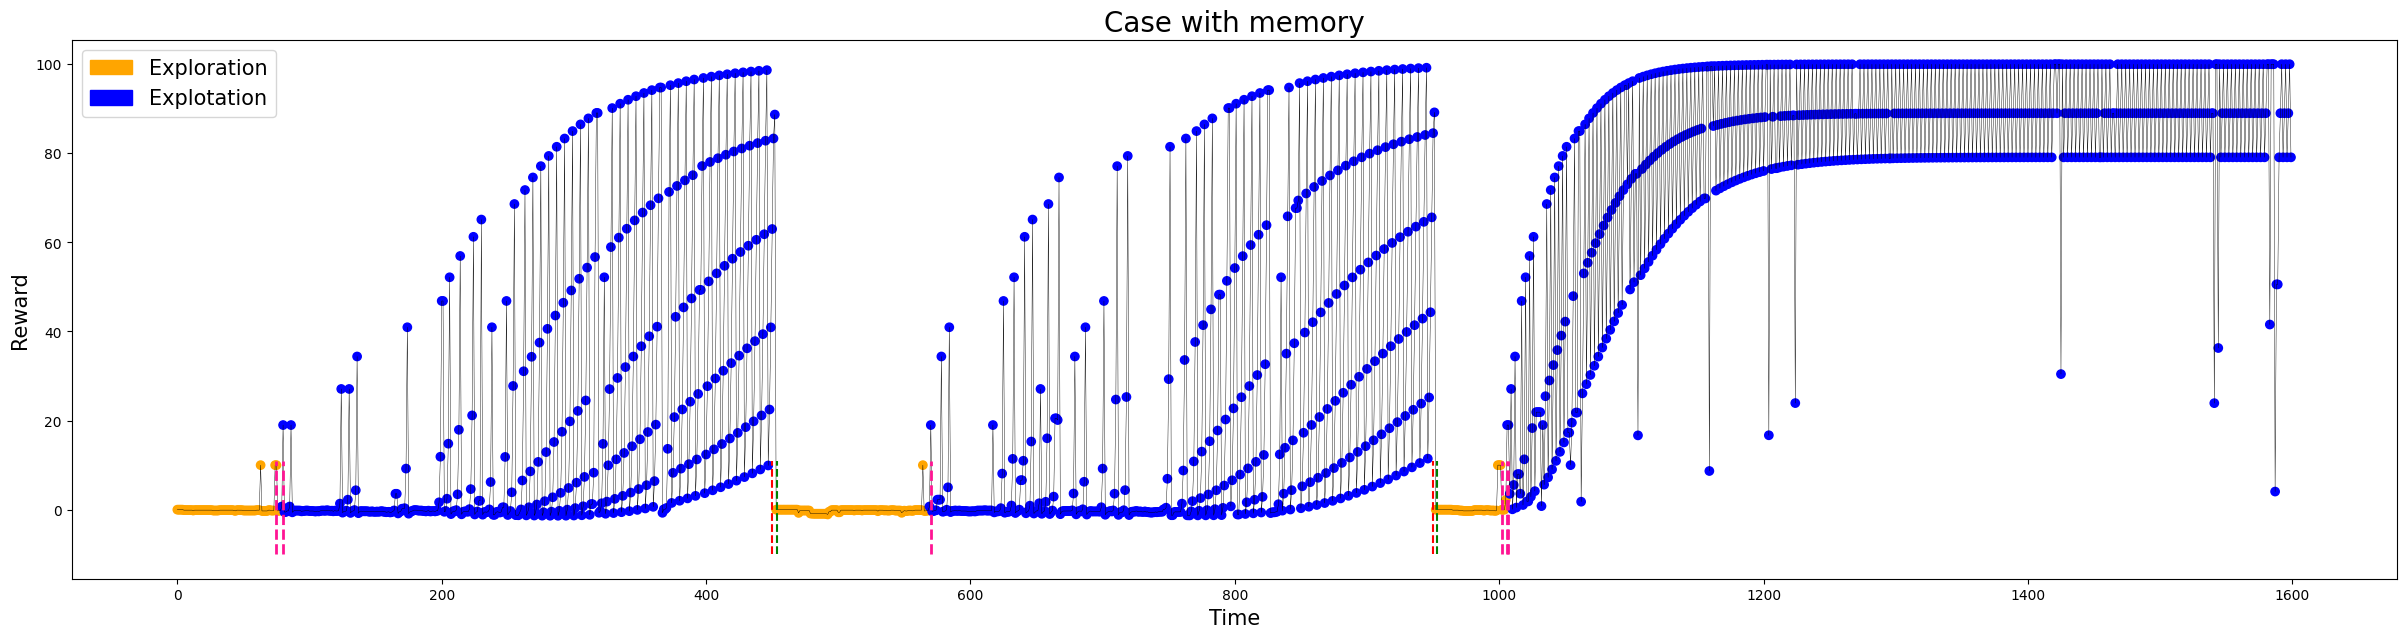

In [4]:
turti = AdaptativeAgent(initial_state=(3,3), 
                        decay_rate=0.015,
                        world_knowledge=GRID_WORLD.copy()
                        )

time = [t for t in range(1600)]
moves = []
rewards = []

changing_times = [450, 950, #300, 450
                  ]

target_pos = (0,0)

for t in time:
    
    if t==changing_times[0]:
        turti.change_world_knowledge(target_pos, -1)
        turti.change_world_knowledge((6,6), 100)
        target_pos = (6,6)
    elif t==changing_times[1]:
        turti.change_world_knowledge(target_pos, -1)
        turti.change_world_knowledge((1,2), 100)
        target_pos = (1,2)
    
    pos_i = turti.current_state
    turti.move(target_pos=target_pos)
    pos_f = turti.current_state
    
    action = 'Explotation' if turti.epsilon_decay(turti.step)<0.2 else 'Exploration'
    
    try:
        reward_obtained = turti.current_reward
    except KeyError:
        reward_obtained = 0
    
    moves.append(action)
    rewards.append(reward_obtained)
    
    
plt.figure(figsize=(30,7))
plt.scatter(time, rewards, color = ['blue' if m=='Explotation' else 'orange' for m in moves])
plt.plot(time, rewards, linewidth=0.3, color='k')

for tc in changing_times:
    plt.vlines(x=tc, ymin=-10, ymax=11, color='r', linestyle='--')

for line in turti.adapt_flag:
    plt.vlines(x=line, ymin=-10, ymax=11, color='g', linestyle='--')
    
for line in turti.memory_flag:
    plt.vlines(x=line, ymin=-10, ymax=11, color='deeppink', linestyle='--', linewidth=2)
    
# Crear parches para la leyenda
blue_patch = mpatches.Patch(color='blue', label='Explotation',)
orange_patch = mpatches.Patch(color='orange', label='Exploration')

# Mostrar la leyenda
plt.legend(handles=[orange_patch, blue_patch], loc='upper left', fontsize=15)
plt.ylabel('Reward', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.title('Case with memory', fontsize=20)
plt.show();

### Without Memory


New value to memory added: [135.] in time 120

Outlier detected at (0, 1) in time 456
Starting exploration ...

New value to memory added: [135.  45.] in time 531

Outlier detected at (6, 5) in time 955
Starting exploration ...


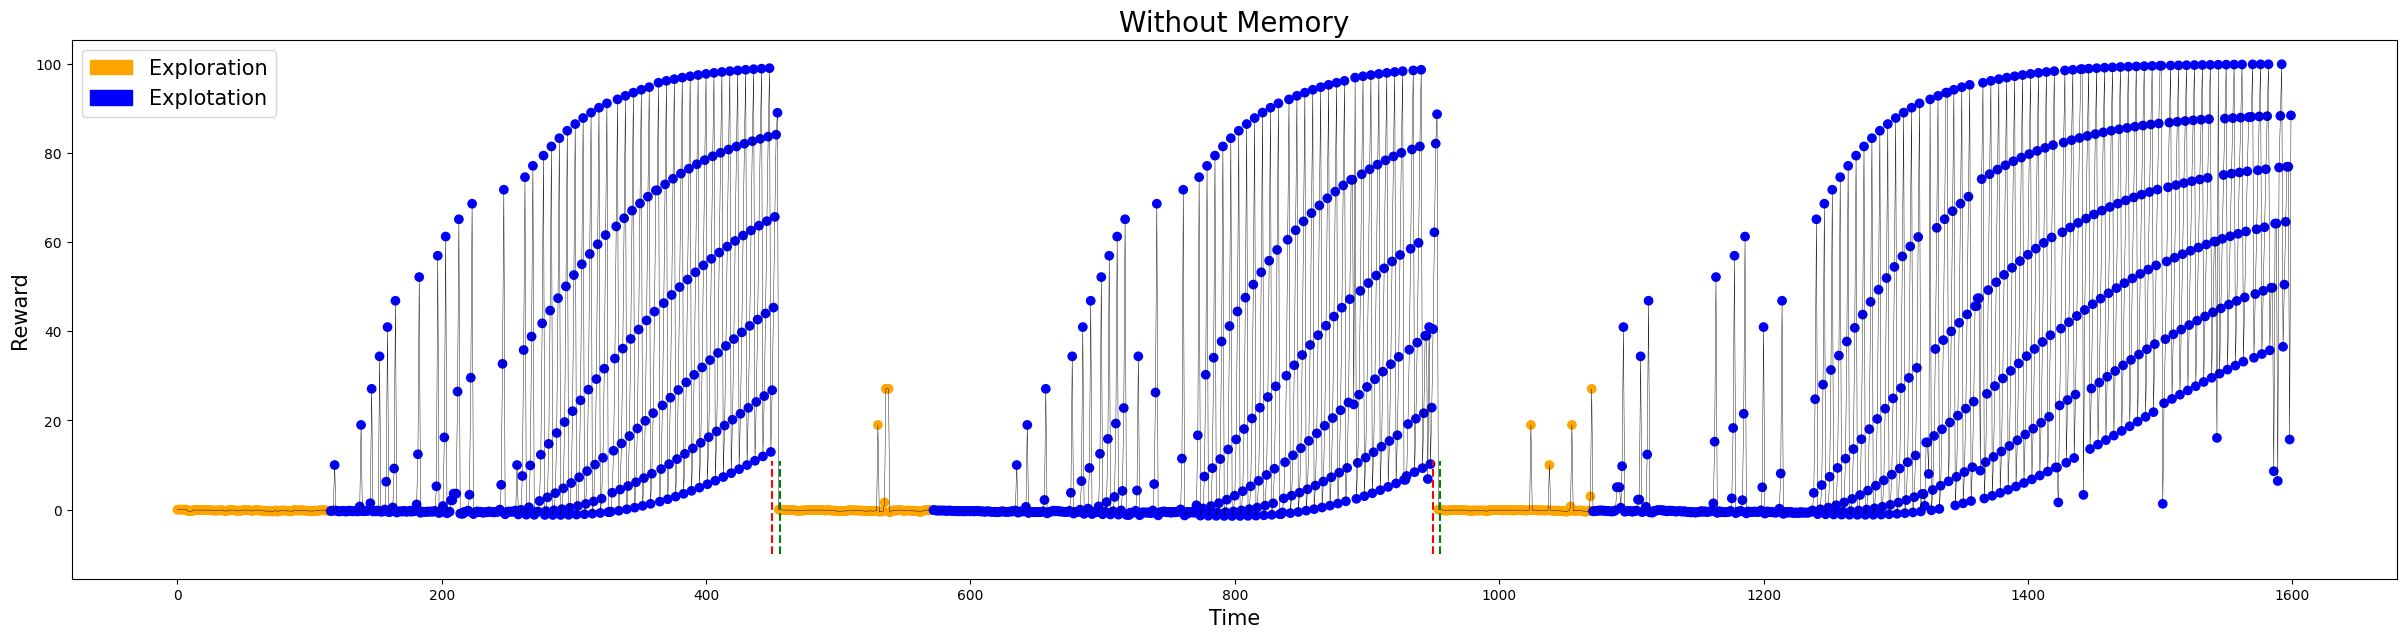

In [182]:
turti = AdaptativeAgent(initial_state=(3,3), 
                        decay_rate=0.015,
                        world_knowledge=GRID_WORLD.copy()
                        )

time = [t for t in range(1600)]
moves = []
rewards = []

changing_times = [450, 950, #300, 450
                  ]

target_pos = (0,0)

for t in time:
    
    if t==changing_times[0]:
        turti.change_world_knowledge(target_pos, -1)
        turti.change_world_knowledge((6,6), 100)
        target_pos = (6,6)
    elif t==changing_times[1]:
        turti.change_world_knowledge(target_pos, -1)
        turti.change_world_knowledge((0,0), 100)
        target_pos = (0,0)
    
    pos_i = turti.current_state
    turti.move(target_pos=target_pos, use_memory=False)
    pos_f = turti.current_state
    
    action = 'Explotation' if turti.epsilon_decay(turti.step)<0.2 else 'Exploration'
    
    try:
        reward_obtained = turti.current_reward
    except KeyError:
        reward_obtained = 0
    
    moves.append(action)
    rewards.append(reward_obtained)
    
    
plt.figure(figsize=(30,7))
plt.scatter(time, rewards, color = ['blue' if m=='Explotation' else 'orange' for m in moves])
plt.plot(time, rewards, linewidth=0.3, color='k')

for tc in changing_times:
    plt.vlines(x=tc, ymin=-10, ymax=11, color='r', linestyle='--')

for line in turti.adapt_flag:
    plt.vlines(x=line, ymin=-10, ymax=11, color='g', linestyle='--')
# Crear parches para la leyenda
blue_patch = mpatches.Patch(color='blue', label='Explotation',)
orange_patch = mpatches.Patch(color='orange', label='Exploration')

# Mostrar la leyenda
plt.legend(handles=[orange_patch, blue_patch], loc='upper left', fontsize=15)
plt.ylabel('Reward', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.title('Without Memory', fontsize=20)
plt.show();

## Animation

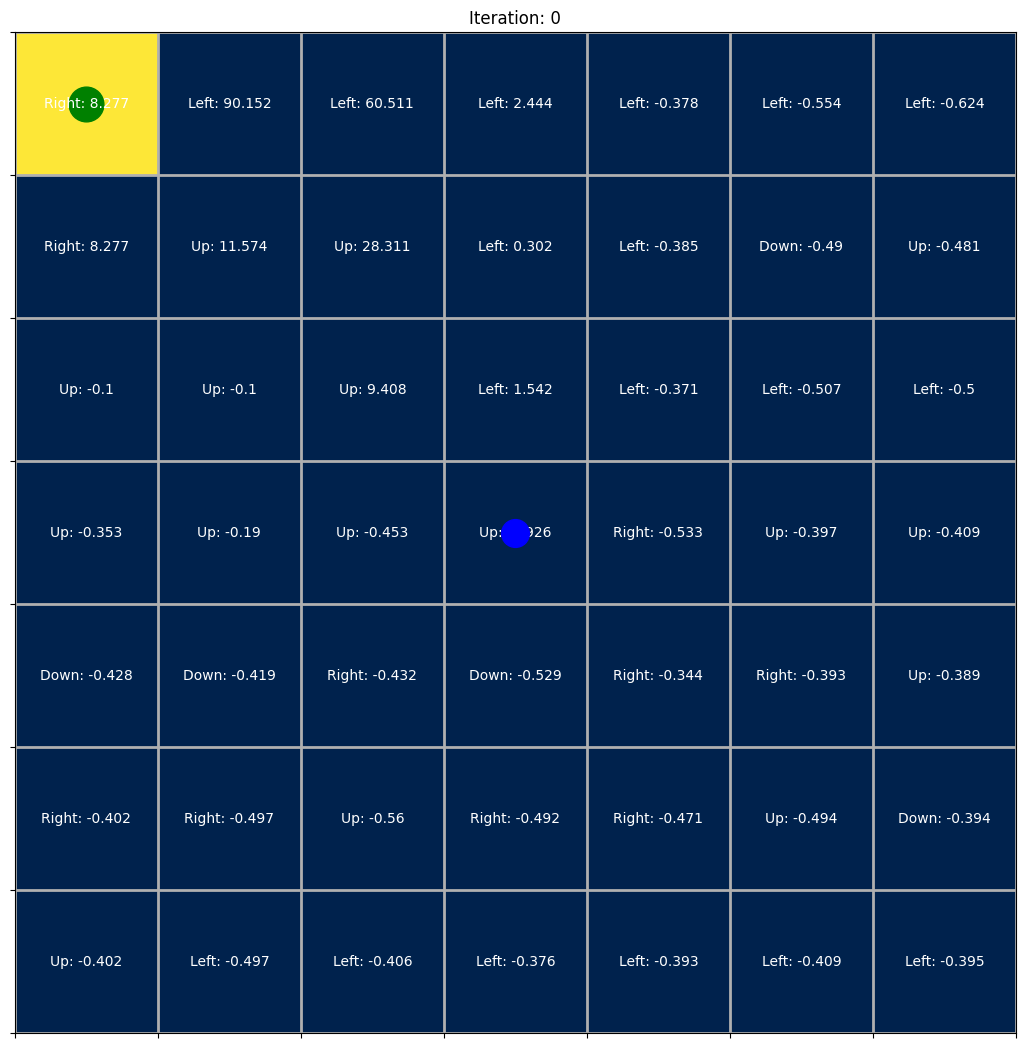

In [35]:
turti = AdaptativeAgent(initial_state=(3,3), 
                        decay_rate=0.01,
                        world_knowledge=GRID_WORLD.copy()
                        )

fig, ax = plt.subplots(figsize=(13, 13))


ct_1 = 180
ct_2 = 400
ct_4 = 550

def update(ite):
    '''    
    if ite == ct_1:
        turti.change_world_knowledge(TARGET_POS1, (-10)*(-1)**changing_times.index(ite))
        turti.change_world_knowledge(TARGET_POS2, (10)*(-1)**changing_times.index(ite))
    elif ite == ct_2:
        turti.change_world_knowledge((0,1), -7)
        turti.change_world_knowledge((1,1), -7)
        turti.change_world_knowledge((1,0), -7)
        turti.change_world_knowledge((0,0), 20)
    '''    
        
    world_knowledge = GRID_WORLD.copy()
    ax.clear()
    ax.set_title(f'Iteration: {ite}')
    ax.imshow(world_knowledge, cmap='cividis')
    
    ax.set_xticks(np.arange(-.5, N_COLS, 1))
    ax.set_yticks(np.arange(-.5, N_ROWS, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.grid(which='both', linewidth=2)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    
    for i in range(world_knowledge.shape[0]):
        for j in range(world_knowledge.shape[1]):
            best_action, value = turti.get_best_action((i,j))
            ax.text(j, i, f'{best_action}: {round(value, 3)}', ha='center', va='center', color='white')        
    
    
    stage = 'blue' if turti.epsilon_decay(turti.step)<0.3 else 'orange'
    ax.plot(turti.current_state[1], turti.current_state[0], marker='o', markersize=20, color=stage, zorder=10000)
    
    symbol1 = 'go' if turti.world_knowledge[TARGET_POS1] > 0 else 'ro'
    #symbol2 = 'go' if turti.world_knowledge[TARGET_POS2] > 0 else 'ro'
    
    ax.plot(TARGET_POS1[1], TARGET_POS1[0], symbol1, markersize=25)
    #ax.plot(TARGET_POS2[1], TARGET_POS2[0], symbol2, markersize=25)
    
    if ite>ct_2:
        ax.plot(1, 0, 'ro', markersize=25)
        ax.plot(1, 1, 'ro', markersize=25)
        ax.plot(0, 1, 'ro', markersize=25)
    
    
    if ite>0:
        turti.move(target_pos=TARGET_POS1)
    return ax

ani = animation.FuncAnimation(fig, update, frames=range(300))
ani.save('simulations/q_learning_clv3.gif', fps=10)